# Exercise 4: Logistic Regression and Evaluation of Binary Classifiers


### Make sure that you read and fully understand all the guidelines listed below before you proceed with the exercise.

* HW assignments are a significant part of the learning experience in this course and contribute 50% to your final grade. So, make sure to devote the appropriate time to them.
* **Sharing solutions with someone who is not your submitting partner is strictly prohibited**. This includes reading someone else's code or sharing your code / posting it somewhere.
* Appeals regarding submissions that do not follow the guidelines will not be accepted.

## Read the following instructions carefully:

### Guidelines for Programming Exercises:

* Complete the required functions in `hw4.py`. Any modifications to this notebook will not be tested by our automated tests.
* Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise can take several minutes when implemented efficiently, but will take much longer otherwise. Unnecessary loops will result in point deductions.
* You are responsible for the correctness of your code. You can add tests to this jupyter notebook to validate your solution. The contents of this jupyter notebook will not be graded or checked.
* You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/), numpy and pandas only. **Do not import anything else.**
* Use `numpy` version 1.15.4 or higher.
* Your code must run without errors. Code that cannot run will not be graded.
* Include docstrings and comments explaining your code
* Your code will be tested using automated scripts. So, failure to follow the instructions may lead to test failure, which might significantly affect your grade.


### Guidlines for Theoretical Exercises
* Your solution should be written or typed and submitted in a separate file `hw4.pdf`.
* If you scan a handwritten solution, make sure that your handwriting is legible and the scan quality is good.
* You are expected to solve the questions analytically and provide a step-by-step solution.
* It is okay and often recommended to use python to carry out the computations.
* You may use the lecture slides and previous homework assignments as references, unless explicitly asked to prove a result from class.

### Submission Guidelines:
* Submit your solutiuon in a zip file that contains:
  - The `hw4.py` script with your solution to the progamming exercise
  - This notebook with your added tests (this is not checked or graded)
  - The `hw4.pdf` file with your solution to the theoretical exercises.
  
* The name of the zip file should contain your ID(s). For example, `hw4_123456789_987654321.zip` if you submitted in pairs and `hw4_123456789.zip` if you submitted the exercise alone.
* Please use **only a zip** file in your submission.


---
---

## Please sign that you have read and understood the instructions:

### *** 211482559 207253899 ***

---
---


# Part 1: Theoretical Exercise (16 points)

In class we developed the logistic regression model by requiring that the class labeling probability (for class 1) follows is a sigmoid function of the inner product of the feature vector ($x$) and the weight vector ($w$):
$$
\Pr[Y=1|X=x,w] ~~=~~ \sigma(w^\top x) ~~=~~ \frac{1}{1+ e^{-w^\top x}}
$$
Using this function for the class labeling probability, we defined the data likelihood, the binary cross entroy (BCE) loss, and a gradient descent algorithm for minimizing the BCE loss.

In this question, you will derive a model and optimization scheme under the following assumptions on the class labeling probabilities:
$$
\Pr[Y=1|X=x,w] = \Phi(w^\top x), \qquad \Phi(x) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^x e^{-t^2/2} dt.
$$
This is called the *probit probability model* (unlike the logistic probability model in logistic regression).
Recall that $\Phi(x)$ is the CDF of the standard normal variable (with mean 0 and variance 1).
The probit model is similar to logistic regression but uses the cumulative normal distribution
instead of the sigmoid function. Both models typically yield similar results in practice.


1. Derive the log-likelihood $\ell(w;D)$ under this model. You may assume that the marginal probability of the data, $P_X(\{x^{(i)}\}_{i=1}^n)$, does not depend on the weight vector $w$ (as we assumed in the logistic probability model).
2. Express the problem of maximizing the log-likelihood in this model as a problem of minimizing the appropriate binary cross-entropy (BCE) loss. The BCE loss you specify here **should not** be normalized by the number of samples ($n$).
3. Find the gradient of the BCE loss and describe how to minimize it using gradient descent.  

Question 4-6 below are based on a question from a previous exam (Moed B 2024).
In all three questions, consider the training data set $D=\{x^{(i)},y^{(i)} \}_{i=1}^{8}$ specified in the cell below.

In [ ]:
import numpy as np
X = np.array([[1, 1, -1, 2, 4],
              [1, -1, -2, 1, 2],
              [1, 2, 0, 3, 1],
              [1, 0, 1, -1, 3],
              [1, 1, -1, 2, 2],
              [1, -1, -1, 2, 3],
              [1, 2, 3, 1, 1],
              [1, 2, 3, 1, 5]
              ])
y = np.array([1, 0, 1, 0, 1, 0, 1, 1])

4. Should you add a "bias" term $x_0=1$?

5. Assume initial weights `w = [0, 0, 0, 0, 0]` and learning rate $\eta=0.01$. Implement `n_iter=4` steps of the gradient descent algorithm for the probit model. For each step, report the gradient and the BCE loss **after** the update. You should use python code to implement the computation and use `scipy.stats.norm.cdf` and `scipy.stats.norm.pdf` to evaluate the normal CDF and PDF. Use the unnormalized version of the BCE loss here (without dividing by the number of samples). No need to submit your code, just the output.

6. Evaluate the model you obtained at the end of the last iteration above on the trianing set. What is the class label it predicts for each of the eight samples in the training set? On which of the samples does it make a classification error? What is its accuracy? As in (5) above, you should use python code to obtain the results, but you submit only your answers without the code.


# Part 2: Coding Assignment (84 points)

In this coding assignment, you will implement logistic regression to classify handwritten digits from the MNIST dataset.
We will focus on binary classification between digits 8 and 9, where the images have been corrupted with noise.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading and Preparing Data (2 points)

We start by loading the MNIST data and adding random noise to every image.
Make sure the data file ``mnist_8n9.npz`` is in the working directory and then execute the code below.
Each sample consists of 784 integer features in the range $[0,255]$ representing a $28 \times 28$ grayscale image.
The code below loads the data, normalizes the features to range [0,1] and adds random noise to each image.
We then print nine random samples as bitmap images.

Training set contains 11026 samples with 784 features
Test set contains 2757 samples with 784 features


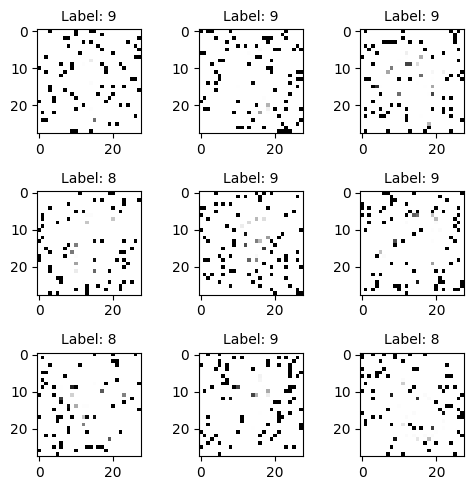

In [3]:
# function adds random noise to given data (train or test)
def add_noise(X, noise_level):
    np.random.seed(42)
    return np.minimum(X + (np.random.rand(X.shape[0], X.shape[1]) > noise_level), 1)

# Load train and test data and normalize pixel values to [0, 1]
data = np.load('mnist_8n9.npz')
X_train = data["X_train"] / 255
X_test  = data["X_test"] / 255
y_train = data['y_train'].astype(int)
y_test  = data['y_test'].astype(int)

# add random noise to train and test data
X_train = add_noise(X_train, noise_level=0.1)
X_test  = add_noise(X_test, noise_level=0.1)

# print basic stats
print("Training set contains", X_train.shape[0], "samples with", X_train.shape[1], "features")
print("Test set contains", X_test.shape[0], "samples with", X_test.shape[1], "features")

# plot nine random images from the training set
sample_indices = np.random.choice(X_train.shape[0], 9, replace=False)
plt.figure(figsize=(5, 5))
for j,i in enumerate(sample_indices):
    plt.subplot(3, 3, j+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_train[i]}', fontsize=10)
plt.tight_layout()
plt.show()

Implement the function `add_bias_term` in `hw4.py` to add a constant 1 as the 0th feature to each sample (2 points).

In [4]:
from hw4 import add_bias_term

X_train = add_bias_term(X_train)
X_test  = add_bias_term(X_test)

# Verify that the size of each instance in the datasets has increased by 1
assert X_train.shape[1] == X_test.shape[1] == 785


## 2. Implementing The Logistic Regression Model (30 points)

Implement the `LogisticRegressionGD` class in `hw4.py`.

This class consists of a constructor (which is already implemented) and four member functions, which you should implement:
`predict_proba`, `predict`, `BCE_loss`, and `fit`.

Recall that the logistic regression model attempts to minimize the binary cross-entropy loss:
$$
BCE(w;D) = -\frac{1}{n}\sum_{i=1}^n [y_i \log(\sigma(w^\top x^{(i)})) + (1-y_i)\log(1-\sigma(w^\top x^{(i)}))] ~,
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid function, $w$ are the model parameters,
$x^{(i)}$ are the input feature vectors, and $y_i$ are the binary labels.
Note that here we use the version of the BCE loss **normalized by the number of samples**.
Make sure to use this version in your implementation.

The code below fits a logistic regression model on the training data.

In [5]:
from hw4 import LogisticRegressionGD

model = LogisticRegressionGD(learning_rate=0.001, max_iter=1000)
model.fit(X_train, y_train)

## 3. Selecting A Learning Rate (10 points)

Implement the function `select_learning_rate` in `hw4.py` to find an effective learning rate for the training data.

This function receives as parameter an array of learning rates.
For each learning rate, fit a logistic regression classifier to the training data using a pre-specified number of GD iterations and record the final BCE loss against the learning rate. Then, return the learning rate that resulted in the smallest loss.

The code below selects a learning rate among a list of values and then trains a logistic regression model using this rate and 10,000 iterations. It then prints the resulting weights and reports their performance on the train and test set.

0.5
0.2
0.1
0.01
0.005
The learning rate attaining the minimal BCE after 1000 GD iterations is 0.01. We pick it.


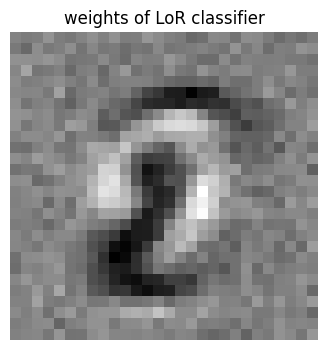

Train BCE: 0.45717901366048597
Train accuracy: 0.8050970433520769
Test BCE: 0.4906655597723763
Test accuracy: 0.7675009067827349


In [6]:
from hw4 import select_learning_rate

# Select the best learning rate based on the minimal BCE loss after 1000 GD iterations
learning_rates = [0.5, 0.2, 0.1, 0.01, 0.005]
max_iter = 1000
learning_rate = select_learning_rate(X_train, y_train, learning_rates, max_iter=max_iter)
print(f"The learning rate attaining the minimal BCE after {max_iter} GD iterations is {learning_rate}. We pick it.")

# Train the model with the selected learning rate
model = LogisticRegressionGD(learning_rate=learning_rate, max_iter=10000)
model.fit(X_train, y_train)

# Convert the weights to a 28x28 image for visualization and plot them
weights = model.w_[1:].reshape(28, 28)
plt.figure(figsize=(4,4))
plt.imshow(weights)
plt.axis('off')
plt.title("weights of LoR classifier")
plt.show()

# Evaluate the model on the training and test sets
print(f"Train BCE: {model.BCE_loss(X_train, y_train)}")
y_pred_train = model.predict(X_train)
print(f"Train accuracy: {np.sum(y_pred_train == y_train) / len(y_train)}")

print(f"Test BCE: {model.BCE_loss(X_test, y_test)}")
y_pred_test = model.predict(X_test)
print(f"Test accuracy: {np.sum(y_pred_test == y_test) / len(y_test)}")

## 4. Evaluating The Model Using Cross Validation (15 points)

Implement the function `cv_accuracy_and_BCE_error` in `hw4.py` for computing the average model accuracy and loss using cross validation (CV).

The purpose of this analysis is to be able to better approximate the test error from the training data.

We would like to get a better assessment of the test error from the train data using cross-validation.
The function partitions the (train) data to `n_folds=5` folds and used 5-fold CV to produce 5 estimates of accuracy and loss.
The CV loss and accuracy is then obtained as the average of these 5 values.

In [7]:
from hw4 import cv_accuracy_and_bce_error

cv_acc, cv_bce = cv_accuracy_and_bce_error(X_train, y_train, n_folds=5)
print("Average CV BCE loss: ", np.mean(cv_bce))
print("Average CV accuracy: ", np.mean(cv_acc))

Average CV BCE loss:  0.6250397363743074
Average CV accuracy:  0.7480497427136463


## 5. Reporting Various Accuracy Metrics (12 points)

In this section you will evaluate the model's performance with greater detail.
We start by examining the *confusion matrix* of our binary classifier.
Recall that this confusion matrix has the following structure:

|                   |   |    True         |   Class    |
|-------------------|---|-----------------|------------|
|                   |   |  0              | 1          |
| **Predicted**     | 0 | #TN             | #FN        |
| $~~~~~~~$**Class**| 1 | #FP             | #TP        |

The cells of this matrix contain counts of the following cases:
- A *True Negative*  (TN) is a negative sample ($y=0$) that is   correctly classified as negative ($\hat y=0$)
- A *True Positive*  (TP) is a positive sample ($y=1$) that is   correctly classified as positive ($\hat y=1$)
- A *False Negative* (FN) is a positive sample ($y=1$) that is incorrectly classified as negative ($\hat y=0$); also called a type II error
- A *False Positive* (FP) is a negative sample ($y=0$) that is incorrectly classified as positive ($\hat y=1$); also called a type I error

These metrics are useful in real-world applications where different types of errors have different consequences.
Consider a medical diagnosis system for detecting a serious disease:
- A false positive (FP) means unnecessarily worrying a healthy patient and potentially prescribing unnecessary treatment
- A false negative (FN) means missing a sick patient who needs treatment - potentially life-threatening

In this case, we may wish to minimize FNs at the expense of potentially adding some FPs to minimize missed diagnoses, even at the cost of more false positives.

We measure these errors using several key metrics. First, looking at errors **per true class**:
Since the number of positive samples ($y=1$) is obtained by #TP + #FN and the number of negative samples ($y=0$) is obtained by #TN + #FP,
we get the following rates:
- *True Positive Rate* (TPR) = #TP / (#TP + #FN)  - the fraction of actual positive samples we correctly   classify as positive
- *True Negative Rate* (TNR) = #TN / (#TN + #FP)  - the fraction of actual negative samples we correctly   classify as negative
- *False Positive Rate* (FPR) = #FP / (#TN + #FP) - the fraction of actual negative samples we incorrectly classify as positive
- *False Negative Rate* (FNR) = #FN / (#TP + #FN) - the fraction of actual positive samples we incorrectly classify as negative

We also care about performance across the **entire dataset**:
Since the total number of samples is #TP + #FP + #TN + #FN, we measure:
- Accuracy = (#TP + #TN) / (#TP + #FP + #TN + #FN) - the fraction of correct predictions overall
- Risk = (#FP + #FN) / (#TP + #FP + #TN + #FN)     - the fraction of incorrect predictions overall

Finally, three especially useful composite metrics that data scientists rely on:
  - *Recall* = TPR = #TP / (#TP + #FN) - measures the fraction of positive predictions out of all **actual positive samples**
  - *Precision* = #TP / (#TP + #FP) - measures the fraction of positive predictions out of all  **positive predictions**
  - *F1* = 2 * (precision * recall) / (precision + recall) - a balanced measure combining precision and recall (their harmonic mean)

In our disease example, high recall would mean catching most sick patients (few false negatives),
while high precision would mean most patients we flag as sick are actually sick (few false positives).
The F1 score helps balance these competing objectives.


Implement the function `calc_and_print_metrics` in `hw4.py` which calculates the various measures mentioned above (12 points).

Consider class "9" as positive ($y=1$) and class "8" as negative ($y=0$).

The code below computes and prints the accuracy measures for the train and test set.

In [8]:

# Calculate the metrics for the LogisticRegression classifier.
from hw4 import calc_and_print_metrics

# Predict the labels for the training and test sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"Training set (total = {y_train.shape[0]}):")
calc_and_print_metrics(y_train, y_pred_train, positive_class=9)

print(f"\nTest set: (total = {y_test.shape[0]}):")
calc_and_print_metrics(y_test, y_pred_test, positive_class=9)


Training set (total = 11026):
#TP: 4422, #FP: 1041, #TN: 4455, #FN: 1108
#TPR: 0.799638336347197, #FPR: 0.189410480349345, #TNR: 0.8105895196506551, #FNR: 0.2003616636528029
Accuracy: 0.8050970433520769, Risk: 0.19490295664792312, Precision: 0.8094453596924767, Recall: 0.799638336347197
F1: 0.8045119621577368

Test set: (total = 2757):
#TP: 1093, #FP: 306, #TN: 1023, #FN: 335
#TPR: 0.7654061624649859, #FPR: 0.23024830699774265, #TNR: 0.7697516930022573, #FNR: 0.234593837535014
Accuracy: 0.7675009067827349, Risk: 0.23249909321726514, Precision: 0.7812723373838456, Recall: 0.7654061624649859
F1: 0.7732578705341351


## 6. Examining The Tradeoff Between Different Error Types Using Receiver Operating Characteristic (ROC) (15 points)

An important feature of (linear) binary classifiers is the possibility to tune their sensitivity to different kinds of errors.
In linear regression models this can easily be achieved by tuning the probability threshold for positive predictions (which can be seen as considering hyperplanes parallel to the original one).
By default, we use a threshold of $\frac 1 2$ and associate a sample $x$ for which $\sigma(w^\top x)>\frac 1 2$ with positive prediction $\hat y = 1$. By increasing this threshold, we decrease the number of positive predictions, which increases the number of false positives and decreases the number of false negatives.

With the *receiver operating characteristic (ROC) curve* we examine the performance of a given binary classifier across different classification thresholds. For each threshold we plot the TPR (Y axis) against the FPR (X axis). This curve allows us to assess the classifier's performance across prediction thresholds:
* A perfect classifier would have a point at (0,1), indicating that there is a threshold that achieves no false positives and all true positives.
* A classifier for which the ROC curve follows close to the diagonal ($y=x$) is no better than a classifier that randomly selects a predicted label.

Most classifiers fall somewhere in between the above two options. A common way to evaluate the classifier across all thresholds is using the  area under the curve (AUC). This provides a single measure that tells us where a classifier falls in the spectrum between a perfect classifier (AUC=1) and a random one (AUC=$\frac 12$).

Implement the function `fpr_tpr_per_threshold` in `hw4.py` which calculates the FPRs and TPRs of a given classifier using a list of thresholds (12 points).

The code below uses the output of this function to plot a ROC curve and compute the AUC for a random classifier and for your logistic regression classifier.

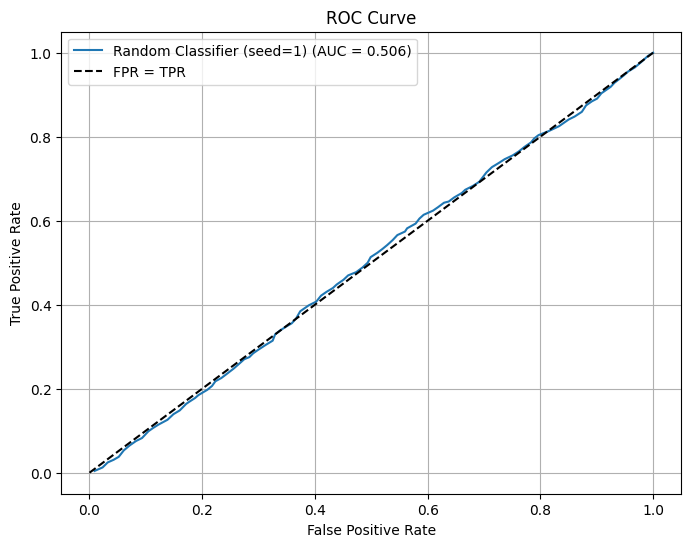

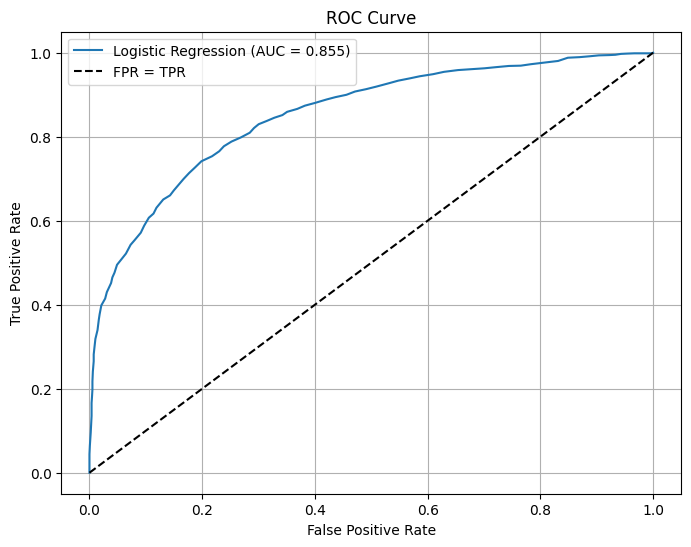

In [9]:
from hw4 import fpr_tpr_per_threshold

def illustrate_roc_curve_and_auc(fpr, tpr, label='ROC Curve'):
    """
    Plot the ROC curve and calculate AUC score for a classifier.

    Parameters
    ----------
    fpr : list or array
        False Positive Rate values.
    tpr : list or array
        True Positive Rate values.
    label : str, optional
        Name of the classifier to display in plot legend. Default is 'ROC Curve'.
    """

    # Compute the AUC score
    auc = 0
    # Sort the fpr and tpr arrays by tpr in descending order
    idcs = np.argsort(tpr)[::-1]
    sorted_fpr = np.array(fpr)[idcs]
    sorted_tpr = np.array(tpr)[idcs]

    for i in range(len(sorted_fpr)-1):
        auc += (sorted_fpr[i] - sorted_fpr[i+1]) * sorted_tpr[i]

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='FPR = TPR')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


# Random classifier probabilities
seed = 1
np.random.seed(seed)
random_classification_probs = np.random.rand(len(y_test))
# Compute FPRs and TPRs for the random classifier
fpr , tpr = fpr_tpr_per_threshold(y_test, random_classification_probs, positive_class=9)
# Plot ROC curve and compute AUC score
illustrate_roc_curve_and_auc(fpr , tpr, label=f'Random Classifier (seed={seed})')
# this classifier is equivalent to a random guess, so its FPR and TPR are about equal and its AUC is 0.5

# Logistic regression classifier probabilities
logistic_classifier_probs = model.predict_proba(X_test)
# Compute FPRs and TPRs for the logistic regression model
fpr , tpr = fpr_tpr_per_threshold(y_test, logistic_classifier_probs, positive_class=9)
# Plot ROC curve and compute AUC score
illustrate_roc_curve_and_auc(fpr , tpr, label=f'Logistic Regression')